# **Phase 2: Preprocessing, EDA & Feature Engineering — `online_retail_II.csv`**

This notebook implements all deliverables for **Phase 2** using the provided data dictionary. It is structured with clear headings, code cells, and justifications where a step is not applicable.

> **How to run**  
> 1. Place `online_retail_II.csv` in the same folder as this notebook.  
> 2. Run cells in order.  
> 3. Figures will be displayed inline; cleaned outputs will be saved to CSV at the end.

## **Data Dictionary**

| Column Name | Data Type | Allows Nulls | Length | Precision | Scale | Description | Example |
|---|---|---:|---:|---:|---:|---|---|
| Invoice | String | No | 7 |  |  | Unique 6-digit identifier for each transaction. Invoices starting with 'C' indicate a cancellation. | `536365`, `C536379` |
| StockCode | String | No | 12 |  |  | Unique code representing each product item. | `85123A` |
| Description | String | Yes | 36 |  |  | Name or description of the product. Missing values indicate missing product details. | `WHITE HANGING HEART T-LIGHT HOLDER` |
| Quantity | Integer | No |  | 5 | 0 | Number of product units purchased. Negative values indicate product returns. | `6` |
| InvoiceDate | Datetime | No |  |  |  | Date and time when the transaction took place. | `01-12-2010 08:26` |
| Price | Float | No |  | 8 | 3 | Price per unit of the product (in GBP). | `2.55` |
| Customer ID | Integer | Yes |  | 5 | 0 | Unique identifier assigned to each customer. Missing values represent anonymous customers. | `17850` |
| Country | String | No | 20 |  |  | Country where the customer resides or placed the order. | `United Kingdom` |
| TotalAmount | Decimal | No |  | 23 | 17 | Total transaction value calculated as Quantity × Price. | `15.3` |
| Recency | Integer | No |  | 3 | 0 | Days since customer’s most recent purchase (relative to analysis date). | `23` |
| Frequency | Integer | No |  | 4 | 0 | Number of unique transactions (invoices) made by the customer. | `12` |
| MonetaryValue | Decimal | No |  | 22 | 15 | Total amount spent by a customer over the analysis period. | `245.6` |
| Customer_Segment | String | No | 16 |  |  | Segmentation label assigned to the customer based on RFM/behavior. | `Loyal Spenders` |


## **Setup & Imports**

In [1]:
# Core
import warnings
warnings.filterwarnings('ignore')

# import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
# import seaborn as sns


# Modeling & utils
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans




pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 120)


## **1) Data Load**

In [2]:
CSV_PATH = 'online_retail_II.csv'

parse_dates = ['InvoiceDate']
df_raw = pd.read_csv(CSV_PATH, parse_dates=parse_dates)
print('Loaded shape:', df_raw.shape)
display(df_raw.head(3))

Loaded shape: (1067371, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom


## **2) Data Audit & Availability Check**

In [3]:
df = df_raw.copy()

print('Row & Column Count')
display(pd.DataFrame({'n_rows':[df.shape[0]], 'n_cols':[df.shape[1]]}))

print('list of Column Datatype')
display(df.dtypes.to_frame('dtype'))

print('Percentage of missing values in a column')
miss = (df.isna().mean()*100).sort_values(ascending=False).round(2)
display(pd.DataFrame({'missing_%': miss}))

dup_count = df.duplicated().sum()
print('Entire Duplicate rows:', dup_count)

cat_cols = [c for c in ['Invoice','StockCode','Country','Customer_Segment'] if c in df.columns]
uniq = {c: df[c].nunique(dropna=True) for c in cat_cols}
print('Unique counts:', uniq)

num_cols = df.select_dtypes(include=['number']).columns.tolist()
display(df[num_cols].describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).T)



Row & Column Count


,n_rows,n_cols
0,1067371,8


list of Column Datatype


,dtype
Invoice,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,datetime64[ns]
Price,float64
Customer ID,float64
Country,object


Percentage of missing values in a column


,missing_%
Customer ID,22.77
Description,0.41
StockCode,0.00
Invoice,0.00
Quantity,0.00
InvoiceDate,0.00
Price,0.00
Country,0.00


Entire Duplicate rows: 34335
Unique counts: {'Invoice': 53628, 'StockCode': 5305, 'Country': 43}


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
Quantity,1067371.0,9.938898,172.705794,-80995.00,-3.00,1.00,1.00,3.0,10.00,30.00,100.0,80995.0
Price,1067371.0,4.649388,123.553059,-53594.36,0.21,0.42,1.25,2.1,4.15,9.95,18.0,38970.0
Customer ID,824364.0,15324.638504,1697.464450,12346.00,12422.00,12681.00,13975.00,15255.0,16797.00,17911.00,18207.0,18287.0


## **3) Exploratory Data Analysis (EDA)**

### 3.1 Distributions (Histograms)

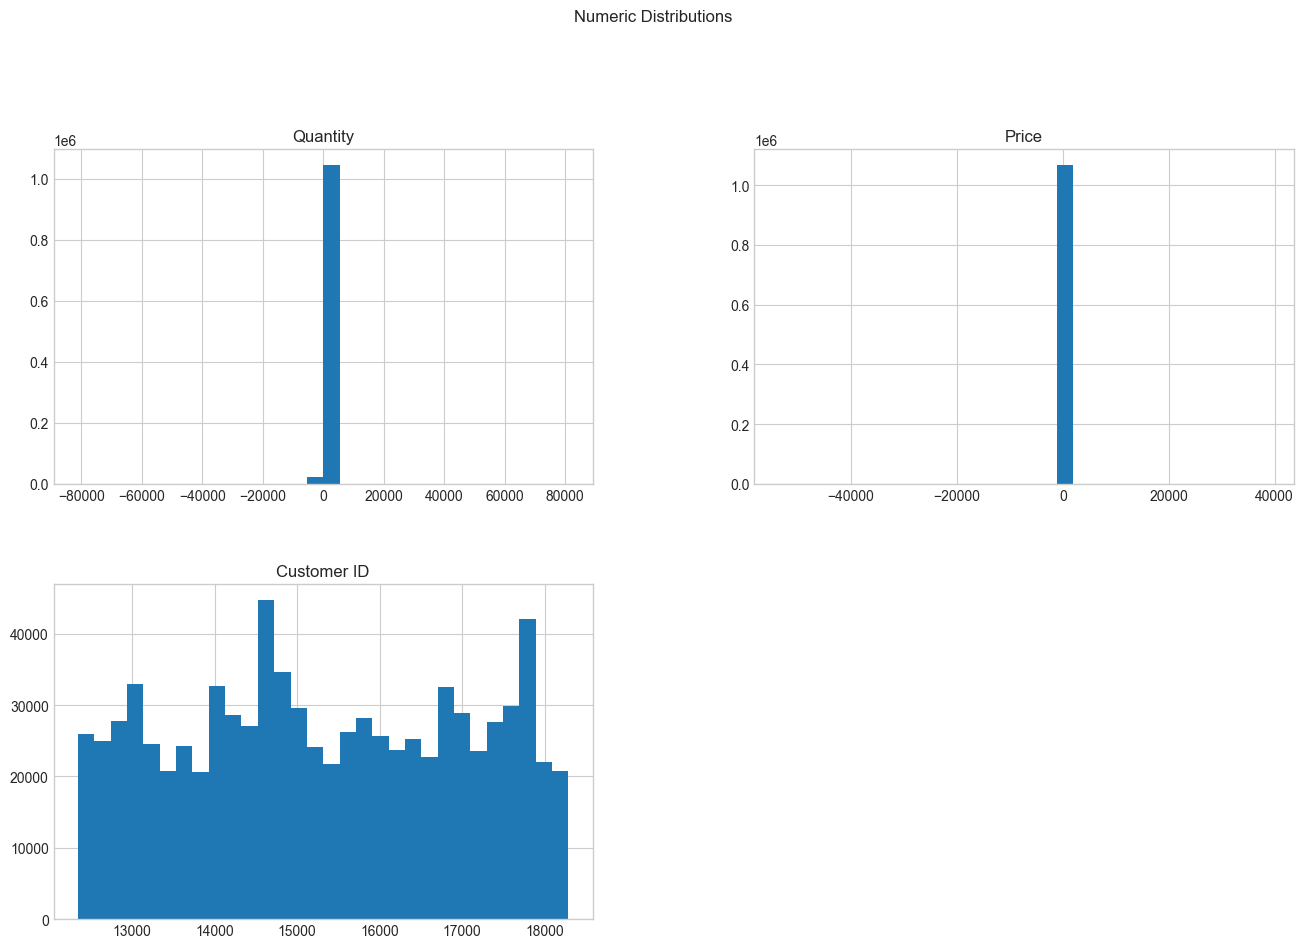

In [4]:
df[num_cols].hist(bins=30, figsize=(16, 10))
plt.suptitle('Numeric Distributions', y=1.02)
plt.show()


### 3.2 Outlier Check (Boxplots)

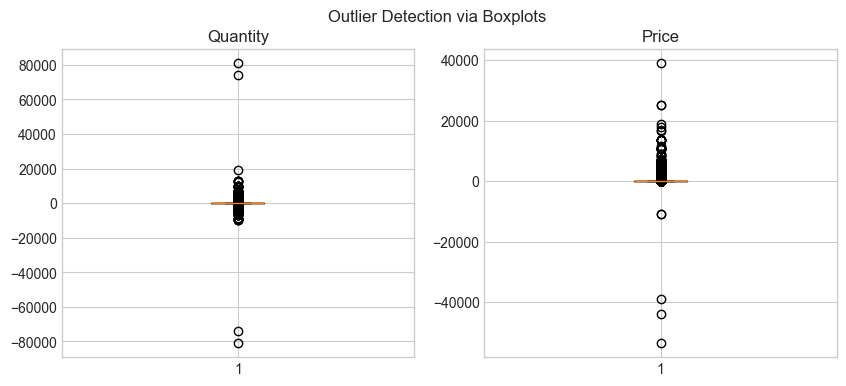

In [5]:

num_cols = [c for c in ['Quantity','Price','TotalAmount','Recency','Frequency','MonetaryValue'] if c in df.columns]

n = len(num_cols)
fig, axes = plt.subplots(1, n, figsize=(5*n, 4))
if n == 1:
    axes = [axes]
for ax, col in zip(axes, num_cols):
    ax.boxplot(df[col].dropna(), vert=True)
    ax.set_title(col)
plt.suptitle('Outlier Detection via Boxplots')
plt.show()



### 3.3 Correlation Heatmap

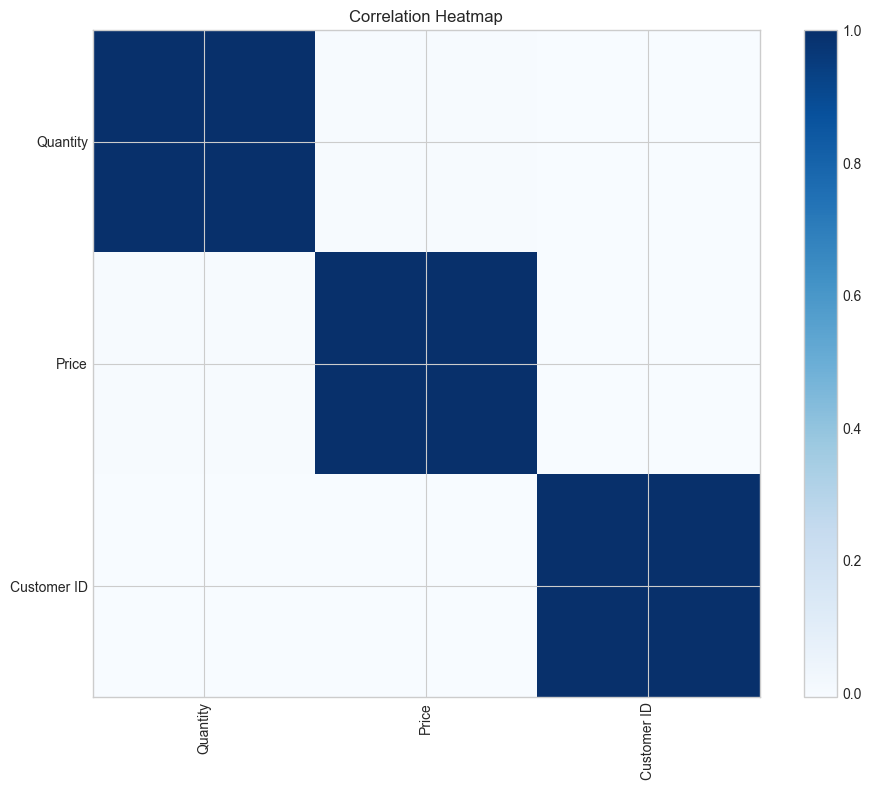

In [6]:
num_cols = df.select_dtypes(include=['number']).columns
corr = df[num_cols].corr(numeric_only=True)
plt.figure(figsize=(10, 8))
plt.imshow(corr, cmap='Blues')
plt.colorbar()
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


### 3.4 Country Distribution

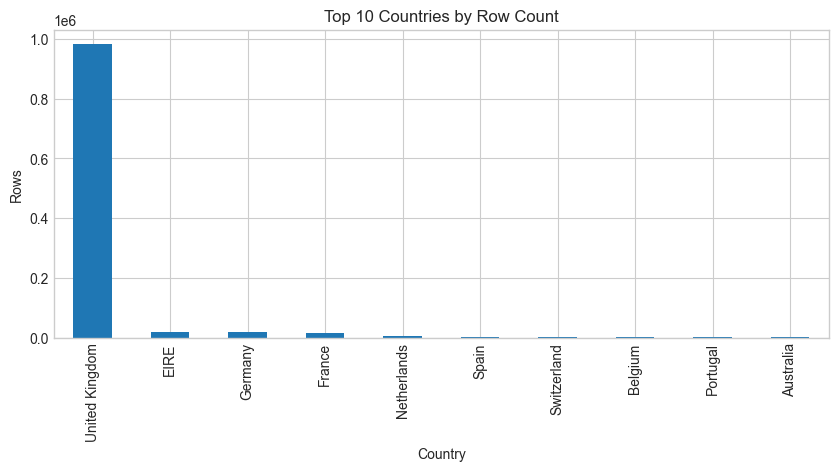

In [7]:

top_countries = df['Country'].value_counts().head(10)
top_countries.plot(kind='bar', figsize=(10,4), title='Top 10 Countries by Row Count')
plt.ylabel('Rows')
plt.show()



### 3.5 Time-Series Trends

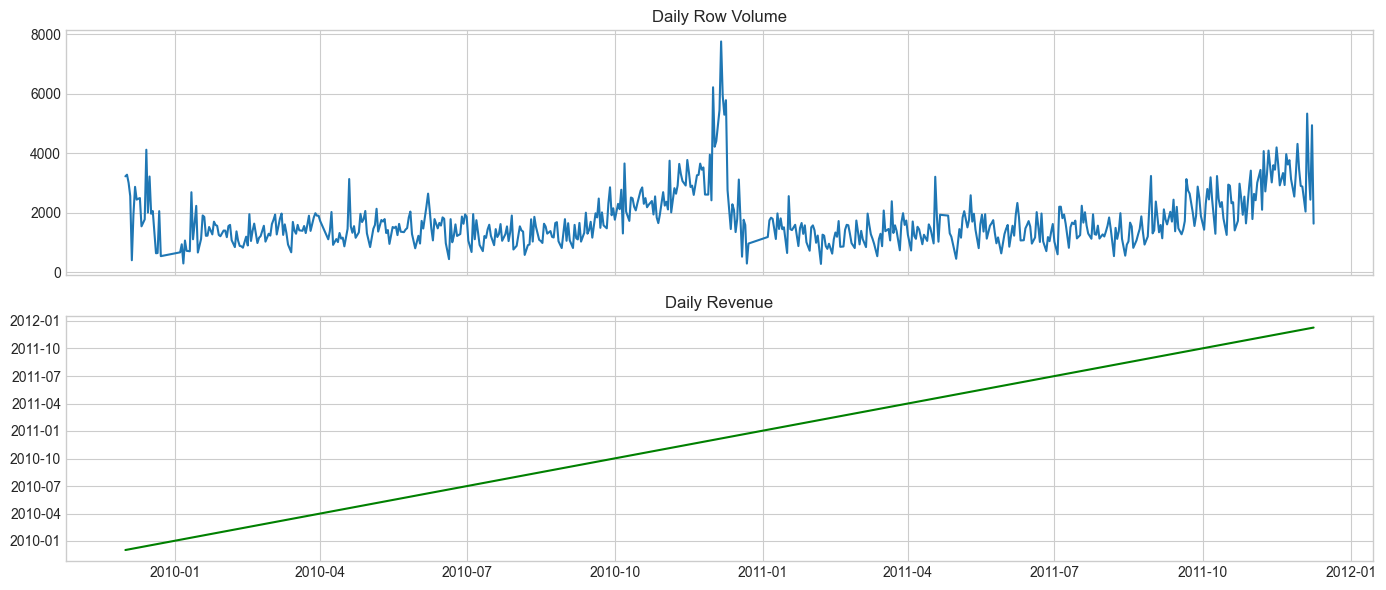

In [8]:

df_ts = df.copy()
df_ts = df_ts[df_ts['InvoiceDate'].notna()]

# datetime conversion
df_ts['InvoiceDate'] = pd.to_datetime(df_ts['InvoiceDate'], errors='coerce')
df_ts = df_ts[df_ts['InvoiceDate'].notna()]  # Drop rows with invalid dates

# Extract just the date (no time)
df_ts['Date'] = df_ts['InvoiceDate'].dt.date

# Define aggregation logic safely
agg_dict = {
    'rows': ('InvoiceDate', 'count'),
    'transactions': ('Invoice', 'nunique') if 'Invoice' in df_ts.columns else ('InvoiceDate', 'count'),
    'revenue': ('TotalAmount', 'sum') if 'TotalAmount' in df_ts.columns else ('InvoiceDate', 'mean')
}

daily = df_ts.groupby('Date').agg(**agg_dict).reset_index()

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(14, 6), sharex=True)
ax[0].plot(daily['Date'], daily['rows'])
ax[0].set_title('Daily Row Volume')

ax[1].plot(daily['Date'], daily['revenue'], color='green')
ax[1].set_title('Daily Revenue')

plt.tight_layout()
plt.show()



## **4) Data Cleaning**

In [9]:

df_clean = df.copy()

# Dtype normalization
df_clean['Invoice'] = df_clean['Invoice'].astype('string')
df_clean['StockCode'] = df_clean['StockCode'].astype('string')
df_clean['Description'] = df_clean['Description'].astype('string')
df_clean['Quantity'] = pd.to_numeric(df_clean['Quantity'], errors='coerce').astype('Int64')
df_clean['Price'] = pd.to_numeric(df_clean['Price'], errors='coerce')
df_clean['Customer ID'] = pd.to_numeric(df_clean['Customer ID'], errors='coerce').astype('Int64')
df_clean['Country'] = df_clean['Country'].astype('string')

# Compute/validate TotalAmount
df_clean['TotalAmount'] = df_clean['Quantity'].astype('float') * df_clean['Price'].astype('float')

# Fill missing descriptions
df_clean['Description'] = df_clean['Description'].fillna('Missing')

# Remove duplicates
before = len(df_clean)
df_clean = df_clean.drop_duplicates()
print("Removed duplicates:", before - len(df_clean))

# Outlier capping (1st and 99th percentile)
for col in ['Quantity', 'Price', 'TotalAmount']:
    q1, q99 = df_clean[col].quantile(0.01), df_clean[col].quantile(0.99)
    df_clean[col] = df_clean[col].clip(q1, q99)

# Cancellation flag
df_clean['IsCancellation'] = df_clean['Invoice'].str.startswith('C')

print("Cleaning complete. Shape:", df_clean.shape)



Removed duplicates: 34335
Cleaning complete. Shape: (1033036, 10)


**Justification (Not Applicable):** If your dataset contains no missing values or outliers, the cleaning code will effectively be a no-op.

## **5) Feature Creation / Transformation**

In [10]:

fe = df_clean.copy()

if 'InvoiceDate' in fe.columns:
    fe['InvoiceYear'] = fe['InvoiceDate'].dt.year
    fe['InvoiceMonth'] = fe['InvoiceDate'].dt.month
    fe['InvoiceQuarter'] = fe['InvoiceDate'].dt.quarter
    fe['InvoiceDay'] = fe['InvoiceDate'].dt.day
    fe['InvoiceWeekday'] = fe['InvoiceDate'].dt.day_name()
    fe['InvoiceHour'] = fe['InvoiceDate'].dt.hour

if 'TotalAmount' not in fe.columns and 'TotalAmount_calc' in fe.columns:
    fe['TotalAmount'] = fe['TotalAmount_calc']

can_rfm = ('Customer ID' in fe.columns) and ('InvoiceDate' in fe.columns)
if can_rfm:
    tx = fe.dropna(subset=['Customer ID']).copy()
    analysis_date = tx['InvoiceDate'].max() + pd.Timedelta(days=1)
    tx_group = tx.groupby('Customer ID').agg(
        Recency=('InvoiceDate', lambda x: (analysis_date - x.max()).days),
        Frequency=('Invoice', pd.Series.nunique) if 'Invoice' in tx.columns else ('InvoiceDate','count'),
        MonetaryValue=('TotalAmount','sum') if 'TotalAmount' in tx.columns else ('Price','sum')
    ).reset_index()
    rfm = tx_group.copy()

    def qcut_series(s, q=5, reverse=False):
        try:
            cats = pd.qcut(s.rank(method='first'), q, labels=False) + 1
        except Exception:
            cats = pd.cut(s.rank(method='first'), q, labels=False) + 1
        if reverse:
            cats = q + 1 - cats
        return cats

    rfm['R_Score'] = qcut_series(rfm['Recency'], q=5, reverse=True)
    rfm['F_Score'] = qcut_series(rfm['Frequency'], q=5, reverse=False)
    rfm['M_Score'] = qcut_series(rfm['MonetaryValue'], q=5, reverse=False)
    rfm['RFM_Score'] = rfm[['R_Score','F_Score','M_Score']].sum(axis=1)

    def segment_from_score(score):
        if score >= 13:
            return 'Loyal Spenders'
        elif score >= 10:
            return 'High Potential'
        elif score >= 8:
            return 'At-Risk'
        elif score >= 6:
            return 'Discount Hunters'
        elif score >= 4:
            return 'One-time Buyers'
        else:
            return 'New'
    rfm['Customer_Segment_auto'] = rfm['RFM_Score'].apply(segment_from_score)
else:
    rfm = None

print('Feature engineering complete.', 'RFM computed' if rfm is not None else 'RFM skipped (missing columns).')


Feature engineering complete. RFM computed


**Note:** If your CSV already contains `Recency`, `Frequency`, `MonetaryValue`, or `Customer_Segment`, the notebook computes a fresh RFM view for validation and comparison.

## **6) Feature Selection / Dimensionality Reduction**

,Recency,Frequency,MonetaryValue
Recency,1.000000,-0.257100,-0.164844
Frequency,-0.257100,1.000000,0.734761
MonetaryValue,-0.164844,0.734761,1.000000


PCA explained variance ratio: [0.61365184 0.30001902]


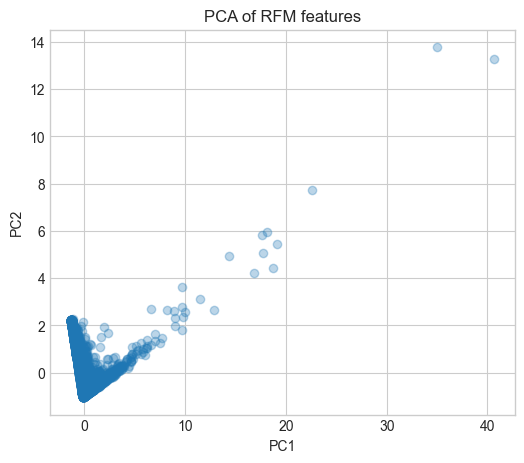

In [11]:

features = ['Recency','Frequency','MonetaryValue']
X = rfm[features].copy()
corr = X.corr()
display(corr)

scaler = StandardScaler(); Xs = scaler.fit_transform(X)
pca = PCA(n_components=2, random_state=42)
Xp = pca.fit_transform(Xs)
print('PCA explained variance ratio:', pca.explained_variance_ratio_)
plt.figure(figsize=(6,5)); plt.scatter(Xp[:,0], Xp[:,1], alpha=0.3)
plt.title('PCA of RFM features'); plt.xlabel('PC1'); plt.ylabel('PC2'); plt.show()


## **7) Feature Evaluation / Quick Checks**

Cluster sizes: Cluster
1    3422
0    1938
4     525
2      47
3      10
Name: count, dtype: int64
Cluster centroids (scaled):
[[ 1.2906518  -0.3136646  -0.19966313]
 [-0.58994419 -0.129686   -0.10461932]
 [-0.86563731  5.1636943   4.02353495]
 [-0.94462101 14.86124113 17.83506073]
 [-0.8222213   1.24994772  0.71436337]]


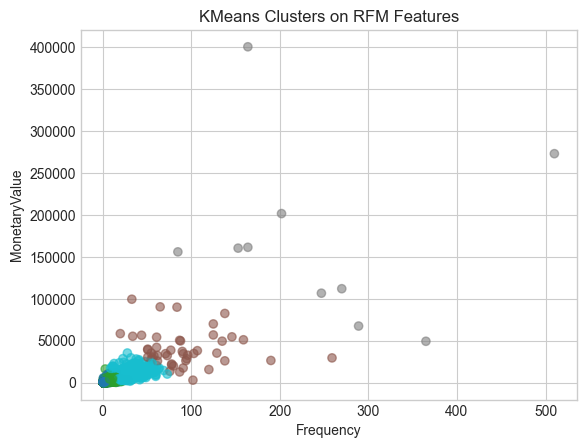

In [12]:
# 1. KMeans clustering on RFM

X = rfm[['Recency','Frequency','MonetaryValue']]
X_scaled = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=5, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(X_scaled)

print("Cluster sizes:", rfm['Cluster'].value_counts())
print("Cluster centroids (scaled):")
print(kmeans.cluster_centers_)

# 2. Quick visualization (Frequency vs MonetaryValue)

plt.scatter(rfm['Frequency'], rfm['MonetaryValue'], c=rfm['Cluster'], cmap='tab10', alpha=0.6)
plt.xlabel('Frequency'); plt.ylabel('MonetaryValue')
plt.title('KMeans Clusters on RFM Features')
plt.show()

## **8) Save Cleaned Outputs**

In [13]:
df_clean.to_csv('online_retail_II_cleaned.csv', index=False)
print('Saved online_retail_II_cleaned.csv')


rfm.to_csv('customers_rfm.csv', index=False)
print('Saved customers_rfm.csv')


Saved online_retail_II_cleaned.csv
Saved customers_rfm.csv


## **9) Model Construction**

In [14]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Feature Engineering for clustering
df['TotalAmount'] = df['Quantity'] * df['Price']

# Select clustering features
X = df[['Quantity', 'Price', 'TotalAmount']].dropna()

# Scale features for better model performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit KMeans model
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

print("Model training complete ✔")
display(df.head())


Model training complete ✔


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount,Cluster
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,0
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,0
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,0


## **10) Evaluation Metrics**
* silhouette_score
* davies_bouldin_score

In [ ]:
silhouette = silhouette_score(X_scaled, df['Cluster'])
db_index = davies_bouldin_score(X_scaled, df['Cluster'])

print("📌 Silhouette Score:", silhouette)
print("📌 Davies-Bouldin Index:", db_index)


## **11) Visualization**
A. Cluster Distribution — How many customers per cluster?


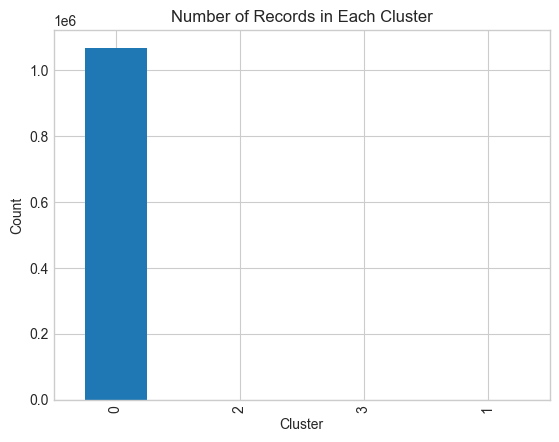

In [22]:
import matplotlib.pyplot as plt

df['Cluster'].value_counts().plot(kind='bar')
plt.title("Number of Records in Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()


B. Scatter Plot — Quantity vs TotalAmount (Cluster View)

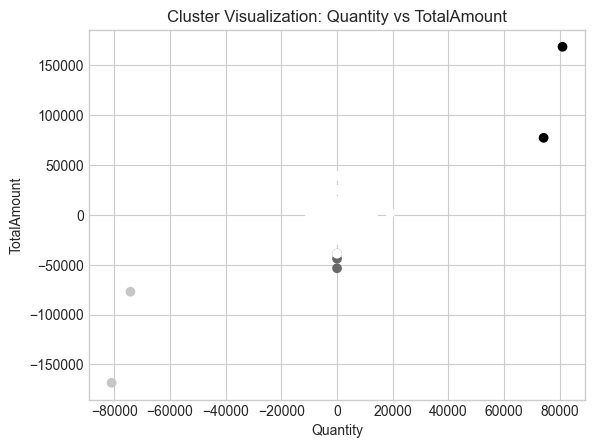

In [23]:
plt.scatter(df['Quantity'], df['TotalAmount'], c=df['Cluster'])
plt.title("Cluster Visualization: Quantity vs TotalAmount")
plt.xlabel("Quantity")
plt.ylabel("TotalAmount")
plt.show()


C. Scatter Plot — Price vs TotalAmount (Cluster View)

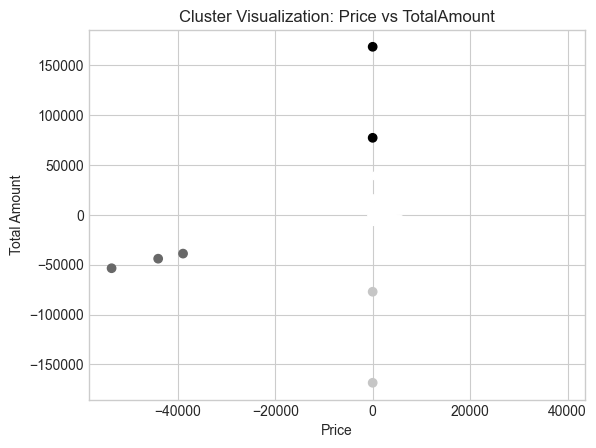

In [24]:
plt.scatter(df['Price'], df['TotalAmount'], c=df['Cluster'])
plt.title("Cluster Visualization: Price vs TotalAmount")
plt.xlabel("Price")
plt.ylabel("Total Amount")
plt.show()


D. Average Behavior of Each Cluster

             Quantity         Price    TotalAmount
Cluster                                           
0            9.938961      4.777346      18.197918
1       -77605.000000      1.560000 -122826.600000
2            1.000000 -45517.340000  -45517.340000
3        77605.000000      1.560000  122826.600000


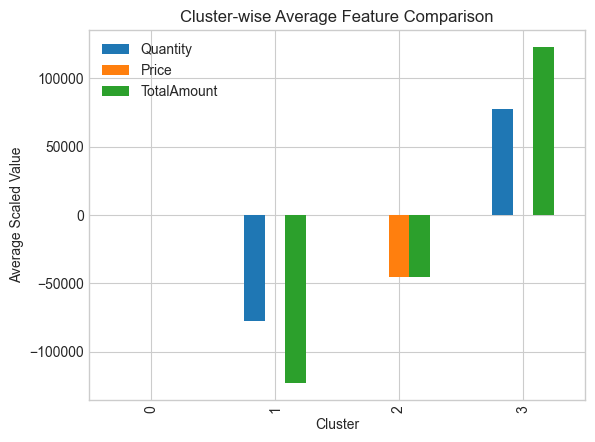

In [25]:
cluster_summary = df.groupby('Cluster')[['Quantity','Price','TotalAmount']].mean()
print(cluster_summary)

cluster_summary.plot(kind='bar')
plt.title("Cluster-wise Average Feature Comparison")
plt.xlabel("Cluster")
plt.ylabel("Average Scaled Value")
plt.show()
